# # 逻辑回归评分模型

In [1]:
import pandas as pd
import numpy as np

In [27]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

In [3]:
# 1.获取数据集

In [4]:
data = pd.read_csv('Acard.txt')
print(data.shape)
print('columns:',list(data.columns))
data.head()

(95806, 13)
columns: ['obs_mth', 'bad_ind', 'uid', 'td_score', 'jxl_score', 'mj_score', 'rh_score', 'zzc_score', 'zcx_score', 'person_info', 'finance_info', 'credit_info', 'act_info']


,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [5]:
# 查看时间片段
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

In [6]:
# 统计月份的样本数--取最后一个月的样本作为时间外样本集
month_samples_count = data.obs_mth.groupby(data.obs_mth).count().to_frame().rename(columns={'obs_mth':'counts'}).reset_index()
month_samples_count

,obs_mth,counts
0,2018-06-30,20565
1,2018-07-31,34030
2,2018-09-30,10709
3,2018-10-31,14527
4,2018-11-30,15975


In [7]:
# 2.建立评分卡 

In [8]:
# 数据划分
train = data[data.obs_mth!='2018-11-30']
print(train.shape)
val = data[data.obs_mth=='2018-11-30']
print(val.shape)

(79831, 13)
(15975, 13)


In [13]:
feature_list = ['person_info', 'finance_info', 'credit_info', 'act_info']
train_x = train[feature_list]
train_y = train['bad_ind']

val_x = val[feature_list]
val_y = val['bad_ind']

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(79831, 4)
(79831,)
(15975, 4)
(15975,)


In [14]:
lr_model = LogisticRegression(C=0.1, class_weight='balanced')
lr_model.fit(train_x, train_y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
# 训练集
train_y_pro = lr_model.predict_proba(train_x)[:,1]
fpr_train, tpr_train, _ = roc_curve(train_y, train_y_pro)
print('train_ks:{}'.format(abs(fpr_train - tpr_train).max()))
# 测试集
val_y_pro = lr_model.predict_proba(val_x)[:,1]
fpr_val, tpr_val, _ = roc_curve(val_y, val_y_pro)
print('val_ks:{}'.format(abs(fpr_val - tpr_val).max()))

train_ks:0.4482453222991063
val_ks:0.4198642457760936


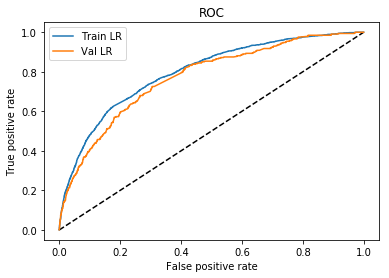

In [33]:
# ROC曲线
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_train, tpr_train, label='Train LR')
plt.plot(fpr_val, tpr_val, label='Val LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='best')
plt.show()

In [68]:
# 模型分数
def score(pro):
    score = 650 + 50 * np.log(pro/(1-pro))
    return score

df_pro = np.hstack((train_y_pro, val_y_pro))
score = score(df_pro)
score = pd.Series(score).to_frame().rename(columns={0:'score'})
score.head()

,score
0,571.583553
1,588.164248
2,631.711351
3,678.252664
4,565.041016
